In [1]:
# Imports 


import sys
# setting path
sys.path.append('../core')
import os
#os.environ["VECLIB_MAXIMUM_THREADS"] = "10"

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

# import dfply
# from dfply import *
# import ray
# import datetime


import os
import warnings
warnings.filterwarnings("ignore")

import torch
torch.cuda.is_available()
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy
import pickle

from subspace import *
from clustering import *
from emalg import *
from helpers import *

%matplotlib inline
plt.style.use('matplotlibrc')

2023-01-14 17:42:18.639386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 17:42:18.722966: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-14 17:42:18.977947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/thinlinc/lib64:/opt/thinlinc/lib:/home/kevin/anaconda3/lib/
2023-01-14 17:42:18.977977: W ten

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-14 17:42:19.257430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 17:42:19.260078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 17:42:19.260154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Simplifications to Sepsis: (1) Rewards no longer dependent on diabetes or no diabetes (averaged across them), (2) Initial state distribution now common across diabetes/no diabetes (averaged across them).

In [2]:
# Get the transition and reward matrix from file
with open("./data/diab_txr_mats-replication.pkl", "rb") as f:
    mdict = pickle.load(f)

envs = []
horizon = 100
    
P = mdict["tx_mat"]
x_dist = mdict["p_initial_state"]
u_dist = mdict["p_mixture"]
gamma = 0.99


nStates = P.shape[2]
nActions = P.shape[1]


#R = np.array([mdict["r_mat"].mean(0) for a in range(nActions)])
R = mdict['r_mat'].mean(0)

pi_b = np.load('data/sepsisPol.npy')
pi_e = pi_b.mean(0)

term = -1

In [3]:
mdp = confound_mdp.ConfoundMDP(P, R, x_dist.mean(0), u_dist, gamma)
dataset = getSamplesMultiProc(10000, mdp, pi_b, horizon, iid=False)

# shape num_traj*horizon, 5 
data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))

# Estimate transition probability
Phat = confound_ope.estimate_P(dataset, mdp)

# Estimate policy
pihat = confound_ope.estimate_pi(dataset, mdp)

# Make both 
for a in range(nActions):
    for s in range(nStates):
        if Phat[a,s].sum() == 0:
            Phat[a,s,term] = 1
        if pihat[s].sum() == 0:
            pihat[s,:] = 1/nActions


pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]

# This is the actual reward_sa
# P(s,a,s') * R(s,a,s')
# R(s,a) = \Sum_{s'} P(s,a,s') * R(s,a,s')
R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
P_spsa = Phat.transpose((2, 1, 0))
n = data.shape[0]


 # behavior value
print("value of pi_b")
returns = confound_mdp.calc_returns(dataset, gamma, horizon)
print(returns.mean())

value of pi_b
0.7807440410480894


In [4]:
def idx_to_trunc(state_idx):
    """idx_to_trunc

    The state index is determined by using "bit" arithmetic, with the
    complication that not every state is binary

    :param state_idx: Given index (720)
    
    Returns a truncated state where the "action states", 
    antibiotics, vasopressors and ventilators, are omitted
    """
    term_base = 720/3 #starts with heart rate

    # Start with the given state index
    mod_idx = state_idx

    hr_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 3
    sysbp_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 2
    percoxyg_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 5
    glucose_state = np.floor(mod_idx/term_base).astype(int)
    
    categ_num = np.array([3,3,2,5])
    state_categs = [
            hr_state,
            sysbp_state,
            percoxyg_state,
            glucose_state]
    sum_idx = 0
    prev_base = 1
    for i in range(len(state_categs)):
        idx = len(state_categs) - 1 - i
        sum_idx += prev_base*state_categs[idx]
        prev_base *= categ_num[idx]
    return sum_idx

for m in tqdm(range(dataset.shape[0])):
    for t in range(dataset.shape[1]):
        #s, a, u, s', r
        dataset[m,t,0] = idx_to_trunc(dataset[m,t,0])
        dataset[m,t,3] = idx_to_trunc(dataset[m,t,3])
        
nStates = int(720/8)

100%|██████████| 9984/9984 [00:08<00:00, 1204.81it/s]


# Subspace Estimation

In [5]:
stateactions = dataset[:, :, [0, 1]]
memorder = 'C'

if memorder == 'F':
    stateactions = (dataset[:,:,0] + dataset[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
else:
    stateactions = (dataset[:,:,0]*nActions + dataset[:,:,1]).astype(int)
states = (dataset[:,:,0]).astype(int)
actions = (dataset[:,:,1]).astype(int)
currstates = dataset[:,:,[0,1]].astype(int)
confounders = dataset[:,:,2].astype(int)
labels = confounders[:,0].astype(int)
nextstates = dataset[:,:,3].astype(int)

L = 2
K = 2
#S = nStates*nActions
#N = len(threes)

In [6]:
sadim = nStates*nActions
spdim = nStates
omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
onehotsa = np.eye(sadim)[stateactions]
#onehotsaflat = copy.deepcopy(onehotsa)
onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order=memorder)
onehotsp = np.eye(np.max(nextstates)+1)[nextstates]
sz = int(onehotsa.shape[0]/3)

In [7]:
#onehotsasub = onehotsa[:sz]
#onehotsaflatsub = onehotsaflat[:sz]
#onehotspsub = onehotsp[:sz]

#onehotsaclust = onehotsa[sz:]
#onehotsaflatclust = onehotsaflat[sz:]
#onehotspclust = onehotsp[sz:]

In [7]:
eigvalsa, eigvecsa = getEig(onehotsa[:sz], onehotsp[:sz], omegaone, omegatwo, K, wt=True, smalldata=False, device='/GPU:0')

2023-01-13 11:37:51.171243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 11:37:51.172635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 11:37:51.172765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 11:37:51.172840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

In [9]:
#np.save('data/sepsisEigVals.npy', eigvalsa)
#np.save('data/sepsisEigVecs.npy', eigvecsa)
#eigvalsa = np.load('data/sepsisEigVals.npy')
#eigvecsa = np.load('data/sepsisEigVecs.npy')

# Clustering

In [8]:
device = "/GPU:0"

hs = np.array([geth(onehotsa[sz:,omegaone,:,:], 
                                     onehotsp[sz:,omegaone,:]), 
                              geth(onehotsa[sz:,omegatwo,:,:], 
                                   onehotsp[sz:,omegatwo,:])], dtype=np.float32)

In [10]:
statmns = computeStat(hs, 
                      eigvecsa, numpy=False, smalldata=False, device="/CPU:0", proj=False)
statmns.shape

  4%|▍         | 4/90 [01:09<24:55, 17.39s/it]


KeyboardInterrupt: 

<BarContainer object of 1000 artists>

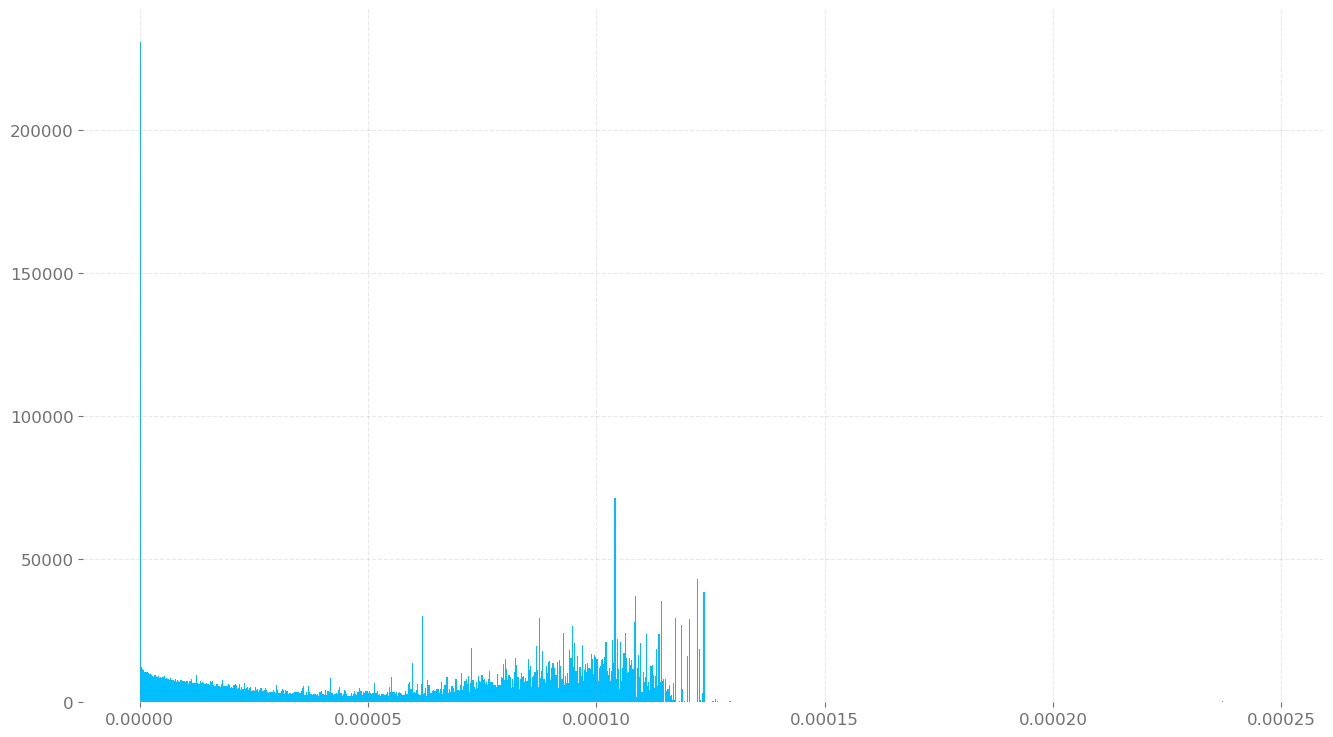

In [12]:
import seaborn as sns
plt.figure(figsize=(16,9))
plt.hist(statmns.flatten(), bins=1000, density=True)[2]
#plt.hist(statmns.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
#sns.kdeplot(statmns.flatten(), bw_adjust=0.5)

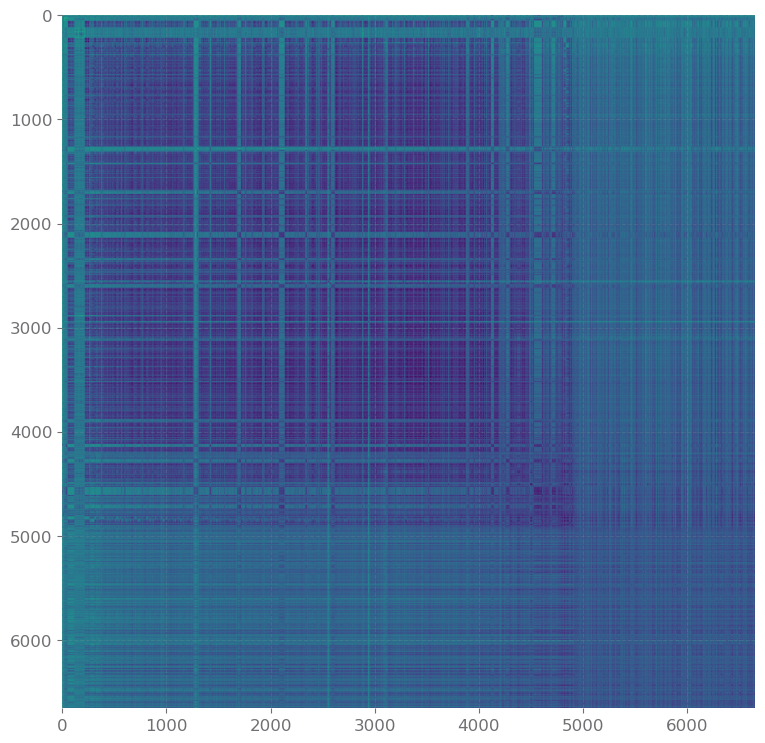

In [13]:
from scipy.cluster.hierarchy import linkage

m = 1-statmns #need similarity matrix
# shuffle
perm = np.random.permutation(len(m))
m = m[perm][:, perm]

# reorder
y = m[np.triu_indices(len(m), k=1)]
Z = linkage(y, method='single', optimal_ordering=True)
perm = np.ravel(Z[:, :2]).astype(np.int32)
perm = perm[perm < len(m)]
m = m[perm][:, perm]

plt.figure(figsize=(16,9))
plt.imshow(1-m)

100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


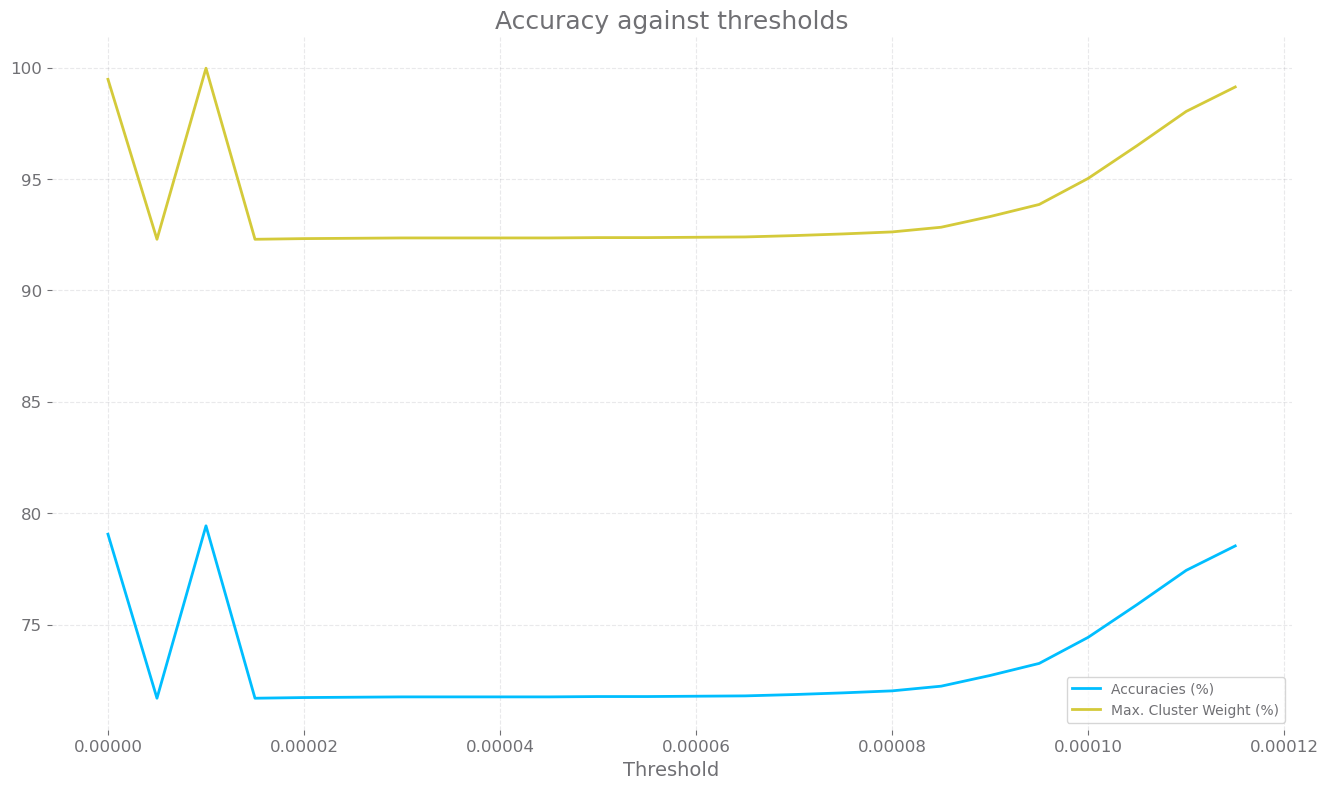

In [14]:
clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
                   lo=0, hi=0.00012, step=0.000005) #0,0.01, 0.0001

In [15]:
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=5.0, 
                             metric='precomputed').fit_transform(statmns) #1-(statmns2 < 0.002)

Text(0.5, 0.98, 't-SNE Visualizations of Clusters and Confounders, Thresholded Distances')

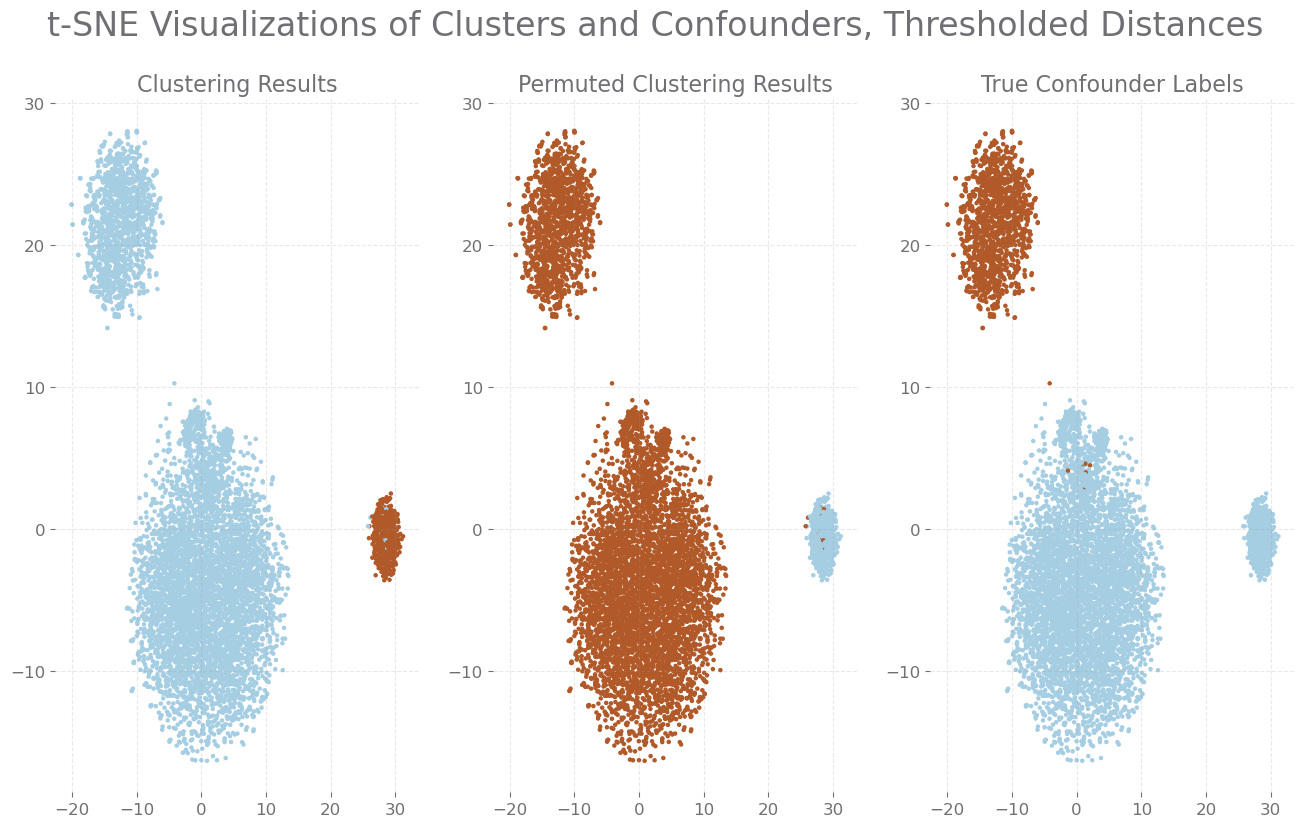

In [16]:
clusterlabs = sklearn.cluster.spectral_clustering((statmns < 0.00005).astype(int), n_clusters=2,
                                                     assign_labels='kmeans')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=clusterlabs, cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-clusterlabs, cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:], cmap='Paired', s=5)
axes[0].set_title('Clustering Results', fontsize=16)
axes[1].set_title('Permuted Clustering Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Clusters and Confounders, Thresholded Distances', fontsize=24)

In [17]:
permutation = np.argmax([np.mean(clusterlabs == confounders[sz:, 0]), 
                    np.mean(clusterlabs != confounders[sz:, 0])])
print(permutation, np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                    np.mean(clusterlabs != confounders[sz:, 0])]))

0 0.7176983173076923


# Model Estimation

In [18]:
Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                         states[sz:,:], 
                         actions[sz:,:], 
                         nextstates[sz:,:],
                        K=K, nStates=nStates, nActions=nActions, hard=True)

# Classification

In [40]:
priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
piclust = getPolicyEstim(states[sz:], actions[sz:], 
                         K, nStates, nActions, preds=clusterlabs, hard=True)
startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
subspaceClass = classify(Phat_ksa, states[:sz,:], actions[:sz,:], 
                       nextstates[:sz,:], piclust, reg=1, 
                   prior=priorclass, startweights = startweights, labs=True)
print('Subspace Classification accuracy:', [np.mean(labels[:sz] == subspaceClass), np.mean(labels[:sz] != subspaceClass)][permutation])

Subspace Classification accuracy: 0.7301682692307693


In [42]:
#denoised model estimate
Phat_ksad = np.array([eigvecsa @ eigvecsa.transpose(0,1,3,2) @ Phat_ksa[k,:,:,:,None] for k in range(K)]).squeeze()
#projected models
projPhat = np.array([eigvecsa.transpose(0,1,3,2) @ Phat_ksa[k,:,:,:,None] for k in range(K)]).squeeze()


priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
piclust = getPolicyEstim(states[sz:], actions[sz:], 
                         K, nStates, nActions, preds=clusterlabs, hard=True)

startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
maxapos = classify(Phat_ksa, states, actions, 
                       nextstates, piclust, reg=1, 
                   prior=priorclass, startweights = startweights, labs=True)
mleprobs = classify(Phat_ksa, states, actions, 
                       nextstates, piclust, reg=1, 
                    prior=priorclass, startweights = startweights, labs=False)

In [61]:
print('MAP estimate accuracy:', [np.mean(labels == maxapos), np.mean(labels != maxapos)][permutation])

MAP estimate accuracy: 0.7153445512820513


In [38]:
expectclass, modelestimclass, loglikclass = em(maxapos, 
                            Phat_ksa, states, actions, 
                        nextstates, labels=labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, max_iter=100,
                                               permute=False, permutation=permutation,
                                               checkin=1, hard=True)

iteration 1 diff 184.2774531774943
9984 9984
accuracy: 0.7118389423076923
-840113.910520193
iteration 2 diff 3.026851330830057
9984 9984
accuracy: 0.7118389423076923
-840081.5142554974
iteration 3 diff 0.0
9984 9984
accuracy: 0.7118389423076923
-840081.5142554974
iteration 4 diff 0.0
9984 9984
accuracy: 0.7118389423076923
-840081.5142554974
iteration 5 diff 0.0
9984 9984
accuracy: 0.7118389423076923
-840081.5142554974
iteration 6 diff 0.0
9984 9984
accuracy: 0.7118389423076923
-840081.5142554974
iteration 7 diff 0.0
9984 9984
accuracy: 0.7118389423076923
-840081.5142554974
iteration 8 diff 0.0
9984 9984
accuracy: 0.7118389423076923
-840081.5142554974
iteration 9 diff 0.0
9984 9984
accuracy: 0.7118389423076923
-840081.5142554974
iteration 10 diff 0.0
9984 9984
accuracy: 0.7118389423076923
-840081.5142554974
log-likelihood: -840081.5142554974


In [57]:
normprobs = np.exp(mleprobs-np.max(mleprobs))
regprobs = 0.8*(normprobs)/np.nansum(np.abs(normprobs), 0) + 0.1*np.ones(mleprobs.shape)
expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                            Phat_ksa, states, actions, 
                        nextstates, labels, 
                        K=2, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, permute=False, permutation=permutation, checkin=1, hard=False)

iteration 1 diff 1305.2215193948832
9984 9984
accuracy: 0.7890625
-4466413.275782731
iteration 2 diff 1121.2795676895062
9984 9984
accuracy: 0.8505608974358975
-842164.1053324991
iteration 3 diff 270.42024001133177
9984 9984
accuracy: 0.9491185897435898
-831074.6820685801
iteration 4 diff 347.49004984421816
9984 9984
accuracy: 0.9705528846153846
-817522.6199057065
iteration 5 diff 148.6680616009898
9984 9984
accuracy: 0.9962940705128205
-815684.2326360876
iteration 6 diff 204.9337147895408
9984 9984
accuracy: 0.9989983974358975
-815279.1336992923
iteration 7 diff 67.14080825535225
9984 9984
accuracy: 0.9989983974358975
-815111.8740032047
iteration 8 diff 22.61669959656107
9984 9984
accuracy: 0.999198717948718
-815242.5561846204
iteration 9 diff 31.763328487157313
9984 9984
accuracy: 0.999198717948718
-815059.7848409545
iteration 10 diff 21.755555555555922
9984 9984
accuracy: 0.999198717948718
-815059.7848409545
iteration 11 diff 1.9777777777777776
9984 9984
accuracy: 0.999198717948718


In [1]:
unifs = np.random.uniform(size=len(dataset))
randlabsoft = np.vstack([unifs, 1-unifs])
randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                              K, nStates, nActions, hard=False)
randlabsoft, randmodelsoft, loglikrandsoft = em(randlabsoft, randmodelsoft,
   states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, min_iter = 20, reg = 0, permute=True, permutation=True, checkin=1, hard=False)

NameError: name 'np' is not defined

100%|██████████| 30/30 [00:19<00:00,  1.50it/s]

0.9998464209401711
1.0
1.0


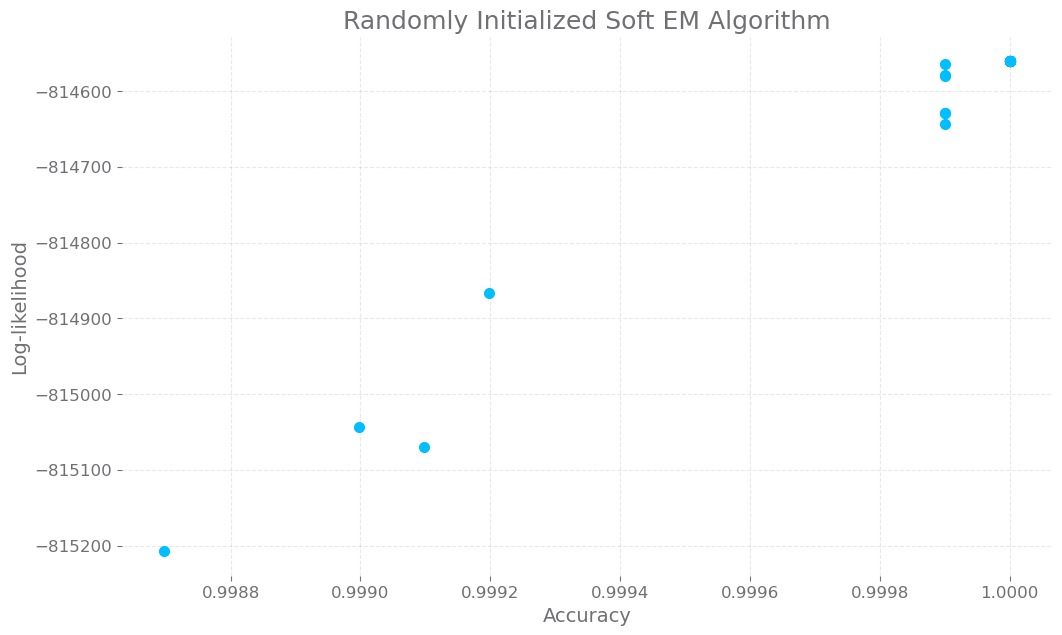

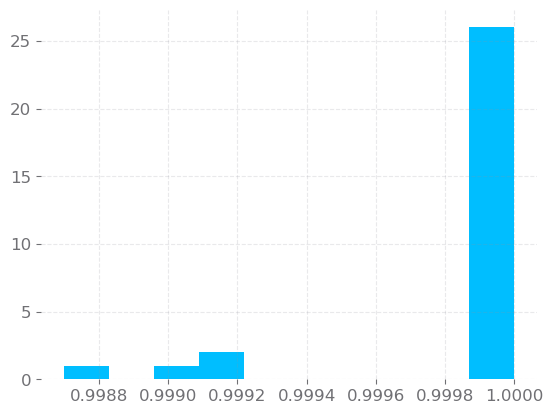

In [59]:
labelsemsoft = []
logliksemsoft = []
for i in tqdm(range(30)):
    unifs = np.random.uniform(size=len(dataset))
    randlabsoft = np.vstack([unifs, 1-unifs])
    randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                              K, nStates, nActions, hard=False)
    randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
   states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=False)
    labelsemsoft.append(randlabsoft)
    logliksemsoft.append(loglikrand)
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
            logliksemsoft)
print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
plt.ticklabel_format(style='plain',useOffset=False)
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Soft EM Algorithm')
plt.show()
plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])
plt.show()

100%|██████████| 30/30 [00:17<00:00,  1.74it/s]

0.9166766826923075
0.9224258814102564
0.9355969551282052


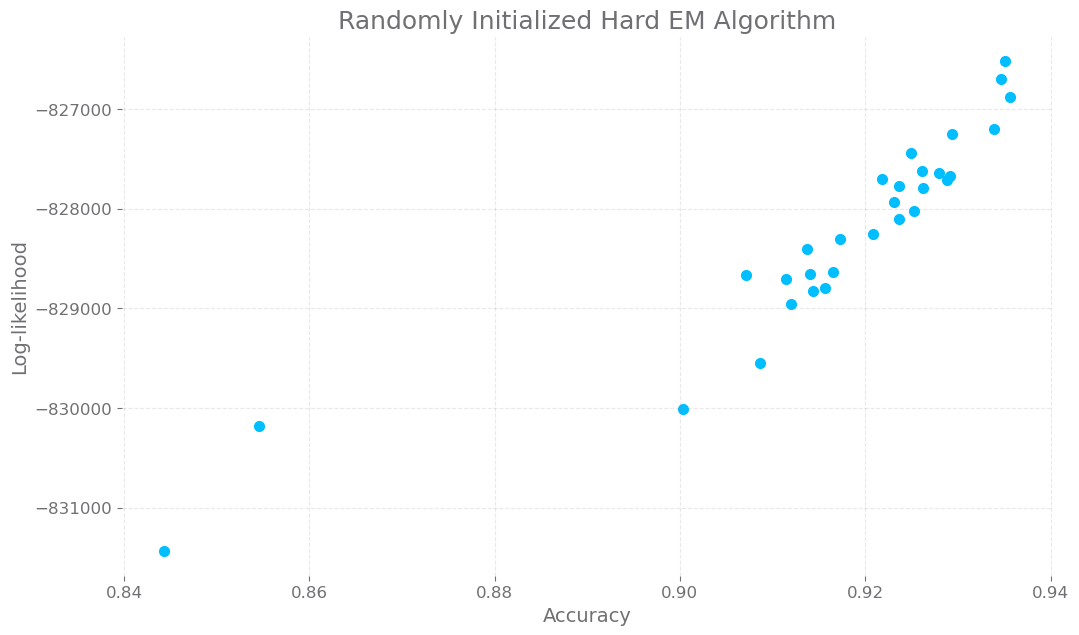

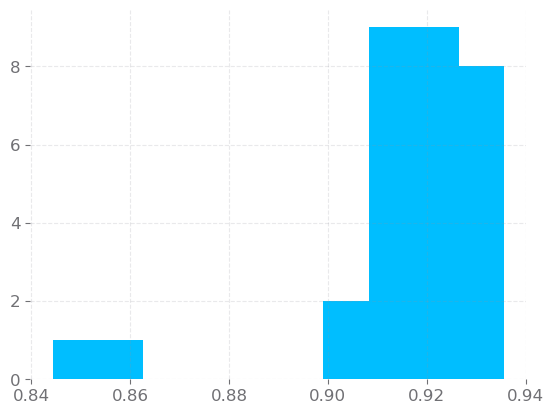

In [38]:
labelsem = []
logliksem = []
for i in tqdm(range(30)):
    randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
    randmodel = getModelEstim(randlabs, states, actions, nextstates,
                              K, nStates, nActions, hard=True)
    randlabs, randmodel, loglikrand = em(randlabs, randmodel,
       states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=True)
    labelsem.append(randlabs)
    logliksem.append(loglikrand)
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem], logliksem)
print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Hard EM Algorithm')
plt.show()
plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem])
plt.show()